<a href="https://colab.research.google.com/github/Adi2005-tecgh/Predictive-Pulse-Harnessing-Machine-Learning-for-Blood-Pressure-Analysis/blob/main/CIPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
)

# Optional gradient boosting
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except ImportError:
    HAS_LGBM = False


In [ ]:
# --- 2️⃣ DATASET LOADING ---
import os
sns.set(style="whitegrid", font_scale=1.1)
os.makedirs("outputs/figures", exist_ok=True)
os.makedirs("outputs/tables", exist_ok=True)

df = pd.read_csv("Weather-related disease prediction.csv")
print(f"Dataset shape: {df.shape}")
display(df.head())

Dataset shape: (5200, 51)


,Age,Gender,Temperature (C),Humidity,Wind Speed (km/h),nausea,joint_pain,abdominal_pain,high_fever,chills,...,facial_pain,shortness_of_breath,reduced_smell_and_taste,skin_irritation,itchiness,throbbing_headache,confusion,back_pain,knee_ache,prognosis
0,4,1,25.826,0.740000,8.289000,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Heart Attack
1,55,0,21.628,0.600000,15.236000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Influenza
2,45,0,13.800,0.817083,4.291992,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Influenza
3,6,0,37.254,0.610000,18.009000,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Dengue
4,70,0,18.162,0.870000,17.916000,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Sinusitis


In [ ]:
# --- 3️⃣ MEMORY OPTIMIZATION ---
def downcast_df(df):
    for col in df.select_dtypes(include=["int64"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="unsigned")
    for col in df.select_dtypes(include=["float64"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="float")
    return df

df = downcast_df(df)
print(f"Memory usage after downcast: {df.memory_usage().sum()/1024**2:.2f} MB")

Memory usage after downcast: 0.33 MB


In [ ]:
# --- 4️⃣ FEATURE GROUPING ---
target = "prognosis"
weather_cols = ["Temperature (C)", "Humidity", "Wind Speed (km/h)"]
demographic_cols = ["Age", "Gender"]
symptom_cols = [
    c for c in df.columns if c not in [target] + weather_cols + demographic_cols
]

print(f"Weather: {weather_cols}")
print(f"Demographics: {demographic_cols}")
print(f"Symptoms: {len(symptom_cols)} columns")

Weather: ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)']
Demographics: ['Age', 'Gender']
Symptoms: 45 columns


In [ ]:
# --- 5️⃣ HANDLE MISSING VALUES ---
df[symptom_cols] = df[symptom_cols].fillna(0)
for col in weather_cols + ["Age"]:
    df[col] = df[col].fillna(df[col].median())
df["Gender"] = df["Gender"].fillna(df["Gender"].mode()[0])

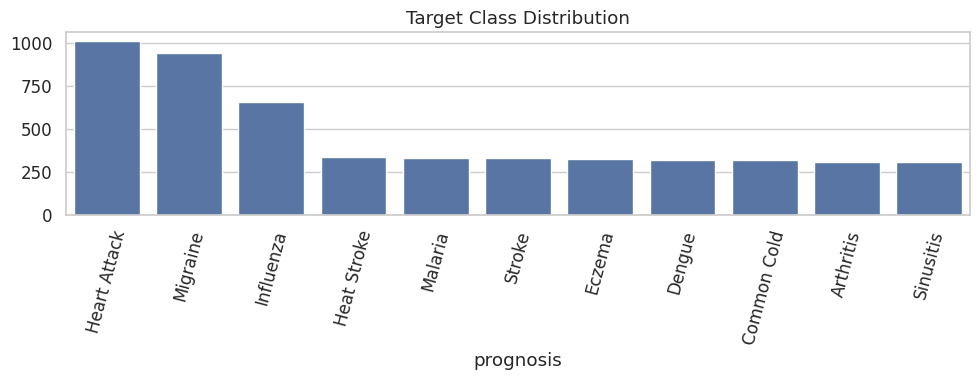

In [ ]:
# --- 6️⃣ BASIC EDA ---
plt.figure(figsize=(10,4))
sns.barplot(x=df["prognosis"].value_counts().index,
            y=df["prognosis"].value_counts().values)
plt.xticks(rotation=75)
plt.title("Target Class Distribution")
plt.tight_layout()
plt.savefig("outputs/figures/target_distribution.png", dpi=150)
plt.show()

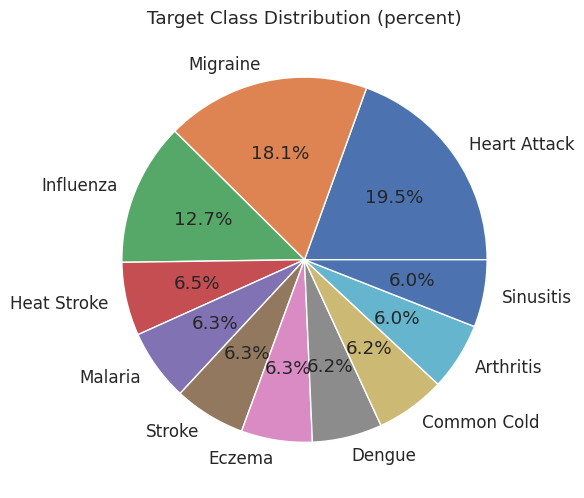

Saved: outputs/tables/class_distribution.csv


In [19]:
# class counts
class_counts = pd.Series(y).map(lambda v: le.inverse_transform([v])[0] if isinstance(v, (int,)) else v) \
               if 'y' in globals() else pd.Series(df['prognosis'])
class_counts = class_counts.value_counts()


# pie
plt.figure(figsize=(6,6))
class_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title("Target Class Distribution (percent)")
plt.ylabel("")
plt.tight_layout()
plt.savefig("outputs/figures/target_distribution_pie.png", dpi=150)
plt.show()

# save table
class_counts.to_csv("outputs/tables/class_distribution.csv", header=["count"])
print("Saved: outputs/tables/class_distribution.csv")


Saved: outputs/tables/top20_symptoms.csv


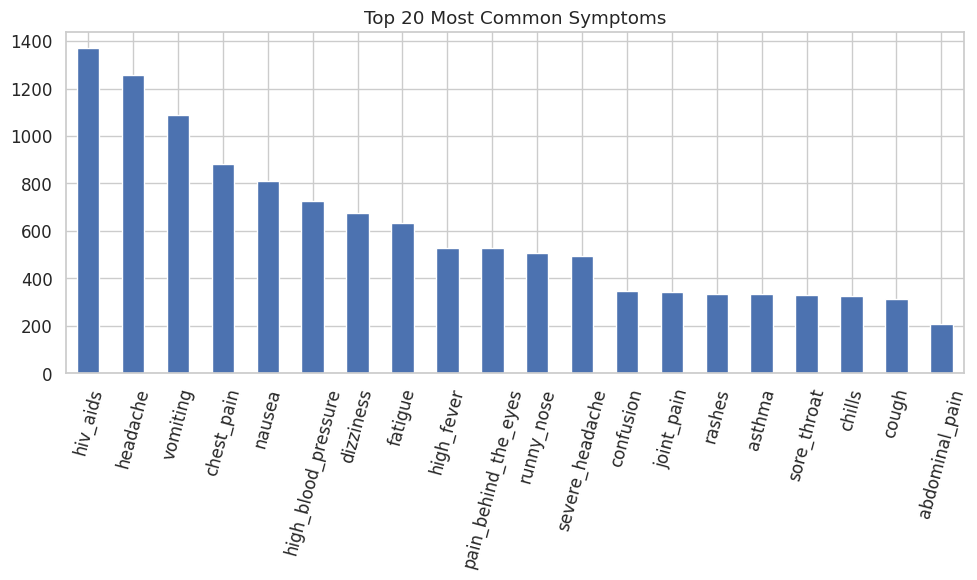

In [20]:
# Sum each symptom column to find how many records have it
symptom_freq = df[symptom_cols].sum().sort_values(ascending=False)
symptom_freq.head(20).to_csv("outputs/tables/top20_symptoms.csv", header=["count"])
print("Saved: outputs/tables/top20_symptoms.csv")

# bar plot top 20
plt.figure(figsize=(10,6))
symptom_freq.head(20).plot(kind='bar')
plt.title("Top 20 Most Common Symptoms")
plt.xticks(rotation=75)
plt.tight_layout()
plt.savefig("outputs/figures/top20_symptoms.png", dpi=150)
plt.show()


In [ ]:
# --- 7️⃣ FEATURE ENGINEERING ---
df["symptom_sum"] = df[symptom_cols].sum(axis=1)
df["temp_x_fever"] = (
    df["Temperature (C)"] * df["high_fever"]
    if "high_fever" in df.columns
    else df["Temperature (C)"]
)

for col in weather_cols:
    print(f"Correlation {col:25s} → {df[col].corr(df['symptom_sum']):.3f}")

Correlation Temperature (C)           → -0.037
Correlation Humidity                  → 0.042
Correlation Wind Speed (km/h)         → 0.006


In [ ]:
# --- 8️⃣ TRAIN/TEST SPLIT ---
X = df.drop(columns=[target])
y = df[target]

le = LabelEncoder()
y_enc = le.fit_transform(y)

SEED = 42 # Define the random state for reproducibility

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=SEED
)

In [ ]:

# --- 9️⃣ PREPROCESSING PIPELINE ---
numeric_features = weather_cols + ["Age", "symptom_sum", "temp_x_fever"]
categorical_features = ["Gender"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
symptom_transformer = "passthrough"

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
    ("sym", symptom_transformer, symptom_cols),
])

In [ ]:
# --- 🔟 CANDIDATE MODELS ---
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, multi_class="ovr", random_state=SEED),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=SEED),
}
if HAS_XGB:
    models["XGBoost"] = XGBClassifier(
        n_estimators=300, learning_rate=0.1, random_state=SEED,
        eval_metric="mlogloss", use_label_encoder=False
    )
if HAS_LGBM:
    models["LightGBM"] = LGBMClassifier(
        n_estimators=300, learning_rate=0.1, random_state=SEED
    )


🔹 Training LogisticRegression ...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Saved → outputs/tables/classification_report_LogisticRegression.csv
Saved → outputs/tables/confusion_matrix_LogisticRegression.csv


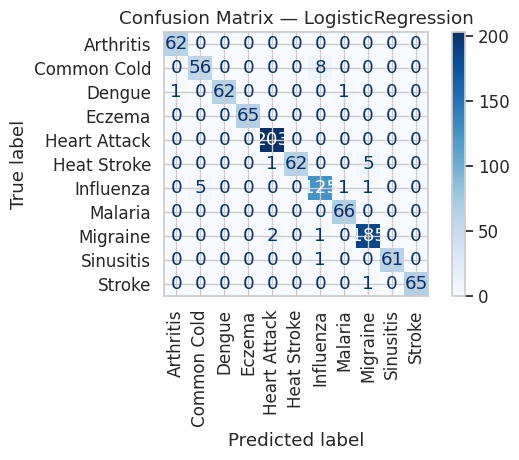

Saved → outputs/figures/cm_LogisticRegression.png

🔹 Training RandomForest ...
Saved → outputs/tables/classification_report_RandomForest.csv
Saved → outputs/tables/confusion_matrix_RandomForest.csv


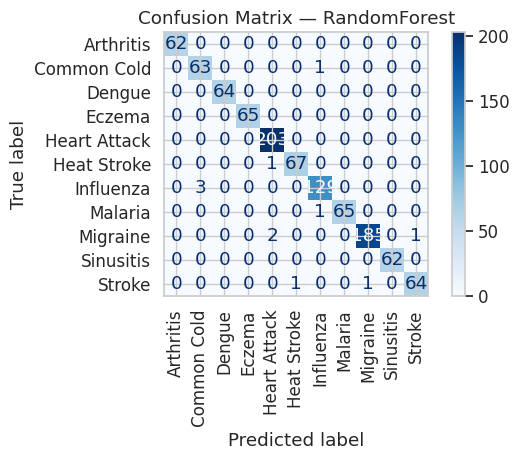

Saved → outputs/figures/cm_RandomForest.png

🔹 Training XGBoost ...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:47:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved → outputs/tables/classification_report_XGBoost.csv
Saved → outputs/tables/confusion_matrix_XGBoost.csv


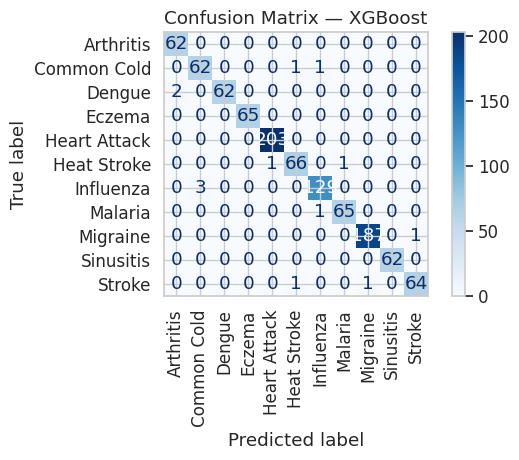

Saved → outputs/figures/cm_XGBoost.png

🔹 Training LightGBM ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 4160, number of used features: 48
[LightGBM] [Info] Start training from score -2.815817
[LightGBM] [Info] Start training from score -2.784194
[LightGBM] [Info] Start training from score -2.780311
[LightGBM] [Info] Start training from score -2.764926
[LightGBM] [Info] Start training from score -1.636236
[LightGBM] [Info] Start training from score -2.734848
[LightGBM] [Info] Start training from score -2.067969
[LightGBM] [Info] Start training from score -2.757321
[LightGBM] [Info] Start training from score -1.709205
[LightGBM] [Info] Start training from score -2.819842
[LightGBM] [Info] Start training from score 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Saved → outputs/tables/classification_report_LightGBM.csv
Saved → outputs/tables/confusion_matrix_LightGBM.csv


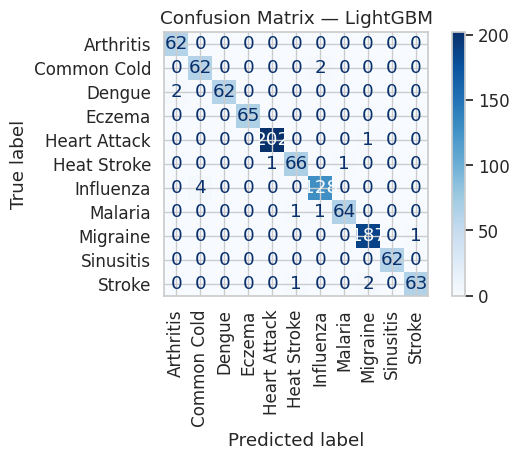

Saved → outputs/figures/cm_LightGBM.png

Saved final summary → outputs/tables/model_summary.csv


,Model,Accuracy,Macro F1
1,RandomForest,0.989423,0.989723
2,XGBoost,0.987500,0.985022
3,LightGBM,0.983654,0.981536
0,LogisticRegression,0.973077,0.972542


In [25]:
# --- 1️⃣1️⃣ TRAIN + EVALUATE + SAVE REPORTS (combined clean block) ---
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

results = []
os.makedirs("outputs/figures", exist_ok=True)
os.makedirs("outputs/tables", exist_ok=True)

for name, model in models.items():
    print(f"\n🔹 Training {name} ...")

    # build and train pipeline
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)

    # predictions
    y_pred = pipe.predict(X_test)

    # classification report
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    acc = report_dict["accuracy"]
    macro_f1 = report_dict["macro avg"]["f1-score"]

    results.append({"Model": name, "Accuracy": acc, "Macro F1": macro_f1})

    # save classification report CSV
    rep_df = pd.DataFrame(report_dict).transpose()
    rep_df.to_csv(f"outputs/tables/classification_report_{name}.csv")
    print(f"Saved → outputs/tables/classification_report_{name}.csv")

    # confusion matrix image + CSV
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
    cm_df.to_csv(f"outputs/tables/confusion_matrix_{name}.csv")
    print(f"Saved → outputs/tables/confusion_matrix_{name}.csv")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues", xticks_rotation=90)
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.savefig(f"outputs/figures/cm_{name}.png", dpi=150)
    plt.show()
    print(f"Saved → outputs/figures/cm_{name}.png")

# Final summary table
results_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False)
results_df.to_csv("outputs/tables/model_summary.csv", index=False)
print("\nSaved final summary → outputs/tables/model_summary.csv")

display(results_df)



In [ ]:
# --- 1️⃣2️⃣ ROC–AUC (MULTI-CLASS) ---
import numpy as np
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
for name, model in models.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        y_score = pipe.predict_proba(X_test)
        auc_score = roc_auc_score(y_test_bin, y_score, multi_class="ovr")
        print(f"{name:15s} ROC-AUC (OvR): {auc_score:.3f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression ROC-AUC (OvR): 1.000
RandomForest    ROC-AUC (OvR): 1.000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:31:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost         ROC-AUC (OvR): 1.000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 4160, number of used features: 48
[LightGBM] [Info] Start training from score -2.815817
[LightGBM] [Info] Start training from score -2.784194
[LightGBM] [Info] Start training from score -2.780311
[LightGBM] [Info] Start training from score -2.764926
[LightGBM] [Info] Start training from score -1.636236
[LightGBM] [Info] Start training from score -2.734848
[LightGBM] [Info] Start training from score -2.067969
[LightGBM] [Info] Start training from score -2.757321
[LightGBM] [Info] Start training from score -1.709205
[LightGBM] [Info] Start training from score -2.819842
[LightGBM] [Info] Start training from score -2.761116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM        ROC-AUC (OvR): 1.000


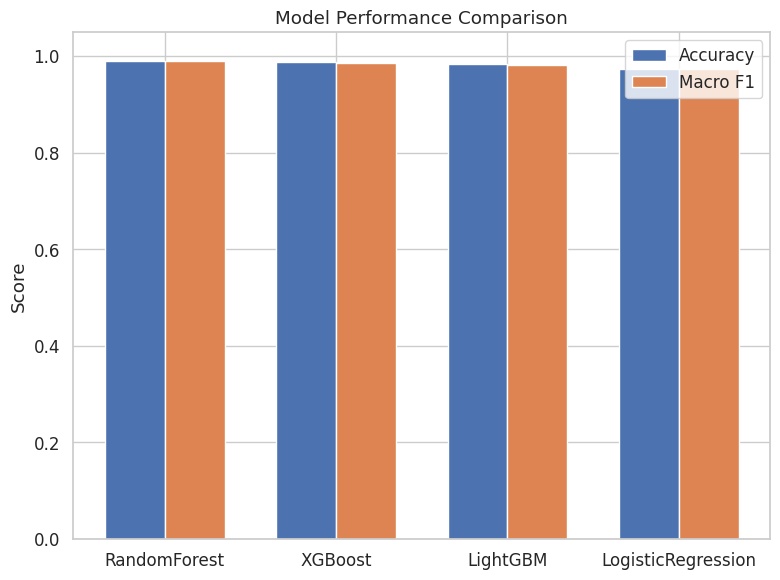

In [ ]:
# --- 1️⃣3️⃣ COMPARISON BAR PLOT ---
plt.figure(figsize=(8,6))
x = np.arange(len(results_df))
bar_w = 0.35
plt.bar(x - bar_w/2, results_df["Accuracy"], width=bar_w, label="Accuracy")
plt.bar(x + bar_w/2, results_df["Macro F1"], width=bar_w, label="Macro F1")
plt.xticks(x, results_df["Model"])
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend()
plt.title("Model Performance Comparison")
plt.tight_layout()
plt.savefig("outputs/figures/model_comparison.png", dpi=150)
plt.show()

In [ ]:
# --- 1️⃣5️⃣ MODEL ACCURACY SUMMARY ---

print("\n📊 Final Model Performance Summary:")
for res in results:
    print(f"{res['Model']:<20s}  Accuracy: {res['Accuracy']:.4f}  |  Macro F1: {res['Macro F1']:.4f}")

# Convert results list → DataFrame (if not already)
results_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False)

# Highlight best model
best_model = results_df.iloc[0]
print("\n🏆 Best Model:")
print(f"Model: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"Macro F1: {best_model['Macro F1']:.4f}")


📊 Final Model Performance Summary:
LogisticRegression    Accuracy: 0.9731  |  Macro F1: 0.9725
RandomForest          Accuracy: 0.9894  |  Macro F1: 0.9897
XGBoost               Accuracy: 0.9875  |  Macro F1: 0.9850
LightGBM              Accuracy: 0.9837  |  Macro F1: 0.9815

🏆 Best Model:
Model: RandomForest
Accuracy: 0.9894
Macro F1: 0.9897


In [16]:
# ----------------------- SAVE / EXPORT ARTIFACTS -----------------------
import os, joblib

os.makedirs("models", exist_ok=True)

# If you saved the fitted pipeline as `pipe` (recommended), save it:
try:
    joblib.dump(pipe, "models/weather_disease_model.joblib")
    print("Saved pipeline -> models/weather_disease_model.joblib")
except NameError:
    # If you didn't use a pipeline variable named `pipe`, but trained `model` and `preprocessor` separately,
    # try to build and save a Pipeline. Uncomment and adjust the following if needed:
    # from sklearn.pipeline import Pipeline
    # trained_pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    # joblib.dump(trained_pipe, "models/weather_disease_model.joblib")
    print("`pipe` not found. Ensure you save your fitted pipeline or model here.")

# Save feature names in exact order your app expects
feature_names = ["Temperature (C)", "Humidity", "Wind Speed (km/h)",
                 "Age", "Gender", "symptom_sum", "temp_x_fever"] + symptom_cols
joblib.dump(feature_names, "models/feature_names.joblib")
print("Saved feature names -> models/feature_names.joblib")

# Save label encoder (the `le` you used to encode y)
try:
    joblib.dump(le, "models/label_encoder.joblib")
    print("Saved label encoder -> models/label_encoder.joblib")
except NameError:
    print("`le` (LabelEncoder) not found. Save your label encoder if you used one.")


Saved pipeline -> models/weather_disease_model.joblib
Saved feature names -> models/feature_names.joblib
Saved label encoder -> models/label_encoder.joblib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')